### linspace rate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ==========================================
# 1. 动力学方程 (Strict LaTeX adherence)
# ==========================================
def dzdt_latex_defined(z, t, p, K1, K2, gamma, r1, r2):
    """
    根据提供的 LaTeX 公式计算 dz/dt
    z: [z1, z2] (complex array)
    """
    z1, z2 = z[0], z[1]
    q = 1.0 - p
    
    # 序参量 Z = q*z1 + p*z2
    Z = q * z1 + p * z2
    Z_conj = np.conjugate(Z)
    
    # 安全措施：防止分母为 0 (尽管在扫描中我们避开了 0 和 1)
    eps = 1e-12
    p_safe = max(p, eps)
    q_safe = max(q, eps)
    
    # --- 严格对照 LaTeX ---
    # dot{z}_1 = -gamma*z1 - (K1/2)*Z*z1^2 + (K1/2)*Z^* + r1*(p/q)*(z2-z1)
    dz1 = -gamma * z1 \
          - (K1 / 2.0) * Z * (z1**2) \
          + (K1 / 2.0) * Z_conj \
          + r1 * (p_safe / q_safe) * (z2 - z1)
          
    # dot{z}_2 = -gamma*z2 - (K2/2)*Z*z2^2 + (K2/2)*Z^* + r2*(q/p)*(z1-z2)
    dz2 = -gamma * z2 \
          - (K2 / 2.0) * Z * (z2**2) \
          + (K2 / 2.0) * Z_conj \
          + r2 * (q_safe / p_safe) * (z1 - z2)
          
    return np.array([dz1, dz2], dtype=complex)

def rk4_step(z, t, dt, f, p, K1, K2, gamma, r1, r2):
    k1 = f(z, t, p, K1, K2, gamma, r1, r2)
    k2 = f(z + 0.5 * dt * k1, t + 0.5 * dt, p, K1, K2, gamma, r1, r2)
    k3 = f(z + 0.5 * dt * k2, t + 0.5 * dt, p, K1, K2, gamma, r1, r2)
    k4 = f(z + dt * k3, t + dt, p, K1, K2, gamma, r1, r2)
    return z + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# ==========================================
# 2. 稳态求解器 (带自动停止)
# ==========================================
def get_steady_state(p, total_rate, K1, K2, gamma, seed=None):
    """
    对给定的 p 和 total_rate，从微小随机值演化直到稳态
    返回: |Z|, |z1|, |z2|
    """
    # 1. 设定参数
    # 稳态关系: p = r2 / (r1 + r2)  => r2 = p * Rate, r1 = (1-p) * Rate
    r2 = p * total_rate
    r1 = (1.0 - p) * total_rate
    
    # 2. 初始条件：微小随机扰动 (Fresh Start)
    if seed is not None:
        np.random.seed(seed)
    # 随机实部和虚部在 [0, 0.01] 之间
    z = (np.random.rand(2) + 1j * np.random.rand(2)) * 0.01
    
    # 3. 迭代控制参数
    dt = 0.02
    t_max = 400.0       # 最大模拟时长，防止死循环
    check_interval = 2.0 # 每隔多少时间检查一次是否收敛
    tolerance = 1e-5    # 稳态判据
    
    current_time = 0.0
    steps_per_check = int(check_interval / dt)
    
    # 记录上一次检查时的模长 (用于判断是否稳定)
    last_abs_z = np.abs(z) 
    
    while current_time < t_max:
        # 跑一个时间块
        for _ in range(steps_per_check):
            z = rk4_step(z, current_time, dt, dzdt_latex_defined, p, K1, K2, gamma, r1, r2)
            current_time += dt
            
            # 数值爆炸保护
            if np.abs(z[0]) > 10: 
                return 10.0, 10.0, 10.0 # 标记为发散
        
        # 检查收敛性
        # 我们检查 |z| (模长) 是否稳定。
        # 这样即使 z 在旋转 (Rotating Frame)，只要幅度不变，也视为稳态。
        current_abs_z = np.abs(z)
        delta = np.max(np.abs(current_abs_z - last_abs_z))
        
        if delta < tolerance:
            # 已收敛
            break
            
        last_abs_z = current_abs_z

    # 4. 计算最终序参量
    q = 1.0 - p
    Z = q * z[0] + p * z[1]
    
    return np.abs(Z), np.abs(z[0]), np.abs(z[1])

# ==========================================
# 3. 主扫描循环
# ==========================================

# 固定参数
N_grid = 50 # 网格分辨率，可根据需要调整 (例如 100)
K1, K2 = -0.5, 1.0
gamma = 0.05

# 扫描范围
p_vals = np.linspace(0.3, 0.95, N_grid)       # 横轴 p
rate_vals = np.linspace(0, 1, N_grid)     # 纵轴 速率

# 结果矩阵
R_mat = np.zeros((N_grid, N_grid))   # |Z| 总
R1_mat = np.zeros((N_grid, N_grid))  # |z1|
R2_mat = np.zeros((N_grid, N_grid))  # |z2|

print(f"开始计算 {N_grid}x{N_grid} 网格...")
print("策略: 每个点从微小随机值独立迭代至稳态。")
start_time = time.time()

for i, rate in enumerate(rate_vals):
    for j, p in enumerate(p_vals):
        # 对每个点调用求解器
        # 使用 i, j 作为随机种子的一部分，保证可重复性，但每个点又略有不同
        seed_val = (i * N_grid + j) % 10000 
        
        R, R1, R2 = get_steady_state(p, rate, K1, K2, gamma, seed=seed_val)
        
        R_mat[i, j] = R
        R1_mat[i, j] = R1
        R2_mat[i, j] = R2
        
    # 进度显示
    if i % 5 == 0:
        elapsed = time.time() - start_time
        print(f"完成行 {i}/{N_grid} (Rate={rate:.3f}), 耗时 {elapsed:.1f}s")

print(f"全部完成. 总耗时: {time.time() - start_time:.2f}s")


开始计算 50x50 网格...
策略: 每个点从微小随机值独立迭代至稳态。
完成行 0/50 (Rate=0.000), 耗时 2.8s
完成行 5/50 (Rate=0.102), 耗时 15.4s
完成行 10/50 (Rate=0.204), 耗时 27.4s
完成行 15/50 (Rate=0.306), 耗时 39.4s
完成行 20/50 (Rate=0.408), 耗时 51.7s
完成行 25/50 (Rate=0.510), 耗时 64.5s
完成行 30/50 (Rate=0.612), 耗时 77.5s
完成行 35/50 (Rate=0.714), 耗时 90.3s
完成行 40/50 (Rate=0.816), 耗时 103.4s
完成行 45/50 (Rate=0.918), 耗时 116.3s
全部完成. 总耗时: 126.71s


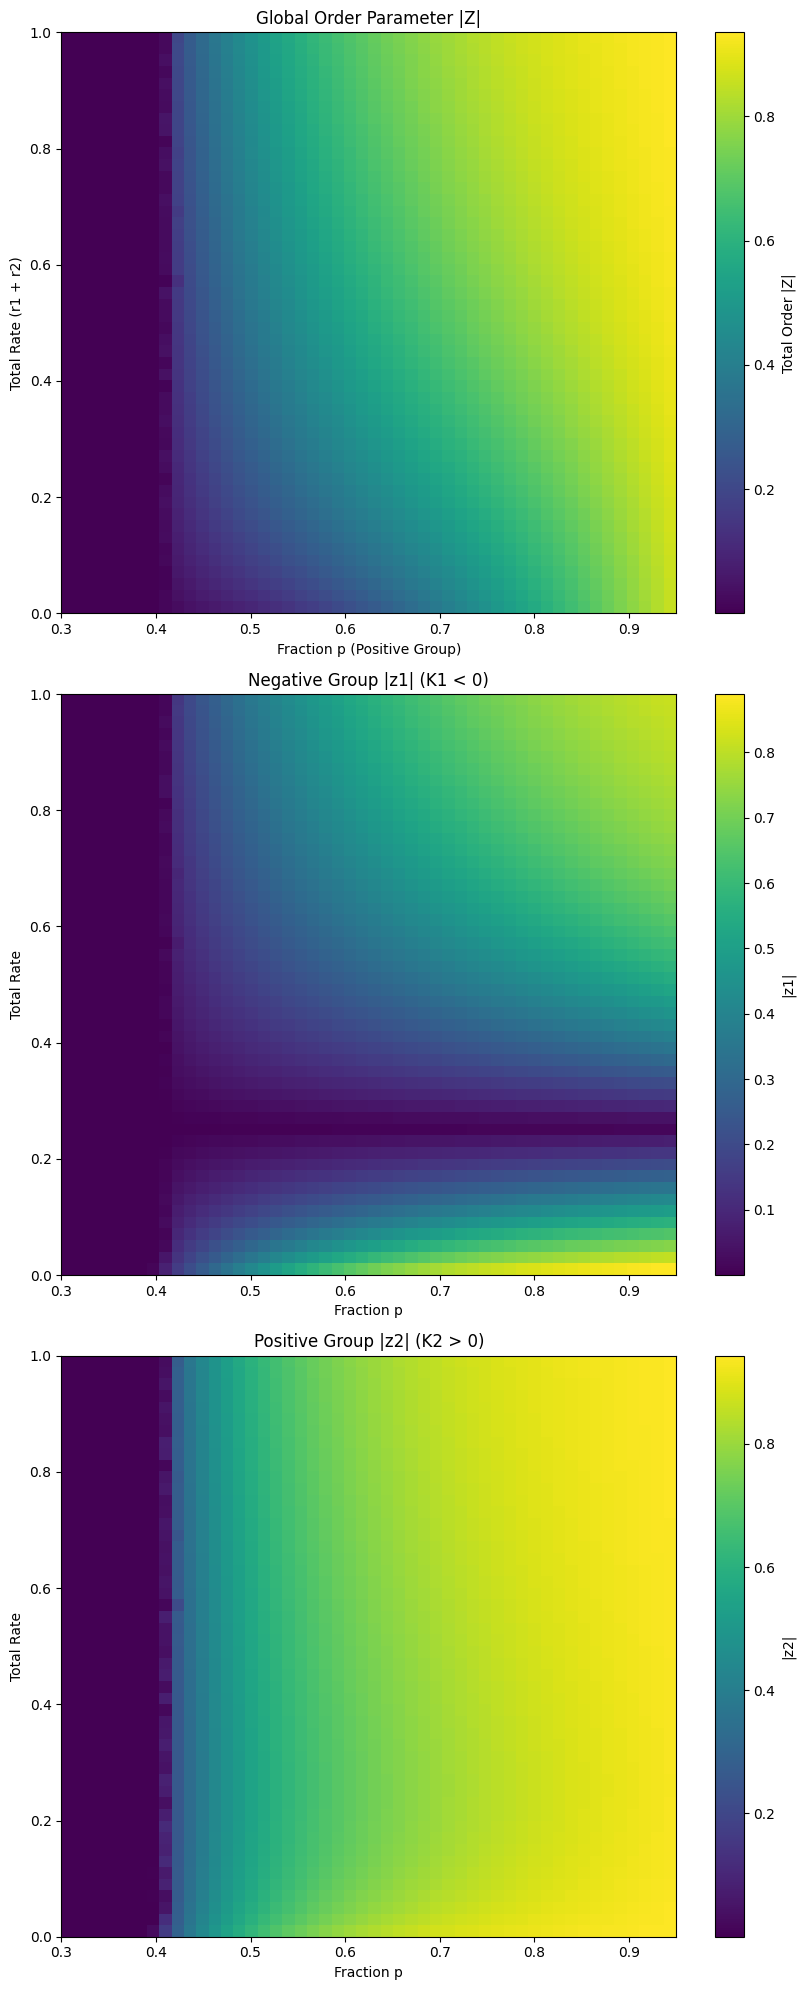

In [2]:
# ==========================================
# 4. 绘图
# ==========================================
plt.figure(figsize=(8.5, 20))

# 设置坐标轴范围
extent = [p_vals[0], p_vals[-1], rate_vals[0], rate_vals[-1]]
#extent = None

# 1. 总序参量 |Z|
plt.subplot(3, 1, 1)
plt.imshow(R_mat, origin='lower', aspect='auto', extent=extent, cmap='viridis')
plt.colorbar(label='Total Order |Z|')
plt.xlabel('Fraction p (Positive Group)')
plt.ylabel('Total Rate (r1 + r2)')
plt.title('Global Order Parameter |Z|')

# 2. 负耦合组 |z1|
plt.subplot(3, 1, 2)
plt.imshow(R1_mat, origin='lower', aspect='auto', extent=extent, cmap='viridis')
plt.colorbar(label='|z1|')
plt.xlabel('Fraction p')
plt.ylabel('Total Rate')
plt.title('Negative Group |z1| (K1 < 0)')

# 3. 正耦合组 |z2|
plt.subplot(3, 1, 3)
plt.imshow(R2_mat, origin='lower', aspect='auto', extent=extent, cmap='viridis')
plt.colorbar(label='|z2|')
plt.xlabel('Fraction p')
plt.ylabel('Total Rate')
plt.title('Positive Group |z2| (K2 > 0)')


plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 文件路径设置
# ==========================================
# 微观数据路径 (CSV)
file_micro_total = '/Users/xiroihs/Documents/K+K- shift/序参量随速率与比例/output_3/scan_R_total.csv'
file_micro_r1    = '/Users/xiroihs/Documents/K+K- shift/序参量随速率与比例/output_3/scan_R_K1.csv'
file_micro_r2    = '/Users/xiroihs/Documents/K+K- shift/序参量随速率与比例/output_3/scan_R_K2.csv'

# 理论数据路径 (NPZ, 假设你之前代码保存的文件名)
file_theory_npz  = 'simulation_results.npz'

# ==========================================
# 2. 读取并对齐数据
# ==========================================

# --- 读取微观数据 (Raw Data) ---
# 注意：先不进行 prepare_df (翻转)，保持原始读取顺序，方便与 numpy 数组匹配
df_total_micro_raw = pd.read_csv(file_micro_total, index_col=0)
df_r1_micro_raw    = pd.read_csv(file_micro_r1, index_col=0)
df_r2_micro_raw    = pd.read_csv(file_micro_r2, index_col=0)

# --- 读取理论数据 ---
try:
    data_theory = np.load(file_theory_npz)
    # 提取矩阵 (假设保存时名字是 R_mat, R1_mat, R2_mat)
    # 注意：理论计算出的矩阵通常行对应的 Index 是从小到大的 (Rate从小到大)
    R_mat_th  = data_theory['R_mat']
    R1_mat_th = data_theory['R1_mat']
    R2_mat_th = data_theory['R2_mat']
    
    print("理论数据加载成功。")
except FileNotFoundError:
    print(f"错误：找不到 {file_theory_npz}。请先运行理论扫描代码生成该文件。")
    raise

# --- 检查形状是否一致 ---
micro_shape = df_total_micro_raw.shape
theory_shape = R_mat_th.shape

if micro_shape != theory_shape:
    raise ValueError(f"网格不匹配！微观数据形状 {micro_shape} vs 理论数据形状 {theory_shape}。\n"
                     f"请检查微观和理论扫描时的 N_grid 参数是否一致。")

print(f"网格形状验证通过: {micro_shape}")

# --- 构建理论数据的 DataFrame ---
# 关键步骤：直接使用微观数据的 index 和 columns 赋给理论数据
# 这样能保证后续相减时，Pandas 不会因为 index 的微小浮点差异而报错
df_total_theory_raw = pd.DataFrame(R_mat_th, index=df_total_micro_raw.index, columns=df_total_micro_raw.columns)
df_r1_theory_raw    = pd.DataFrame(R1_mat_th, index=df_r1_micro_raw.index, columns=df_r1_micro_raw.columns)
df_r2_theory_raw    = pd.DataFrame(R2_mat_th, index=df_r2_micro_raw.index, columns=df_r2_micro_raw.columns)

# ==========================================
# 3. 计算差值 (Micro - Theory)
# ==========================================
# 直接在 Raw 层面做差
df_diff_total_raw = df_total_micro_raw - df_total_theory_raw
df_diff_r1_raw    = df_r1_micro_raw    - df_r1_theory_raw
df_diff_r2_raw    = df_r2_micro_raw    - df_r2_theory_raw

# ==========================================
# 4. 数据后处理 (翻转 Y 轴以符合绘图习惯)
# ==========================================
def prepare_df(data_frame):
    # 确保列名是 float
    data_frame.columns = data_frame.columns.astype(float)
    # 反转行顺序，因为 sns.heatmap 默认把 index[0] 画在最上面
    # 原始数据的 index[0] 通常是最小的 Rate。
    # 我们希望 Y 轴从下往上是 Rate 增大，所以需要把大的 Rate 翻到最上面。
    return data_frame.iloc[::-1]

# 对差值矩阵应用处理
df_diff_total = prepare_df(df_diff_total_raw)
df_diff_r1    = prepare_df(df_diff_r1_raw)
df_diff_r2    = prepare_df(df_diff_r2_raw)

# 准备绘图列表
heatmap_data = [
    (df_diff_total, 'Error in Total $|Z|$ (Micro - Theory)', '$\Delta |Z|$'),
    (df_diff_r1,    'Error in $|Z_1|$ (Negative Coupling)', '$\Delta |Z_1|$'),
    (df_diff_r2,    'Error in $|Z_2|$ (Positive Coupling)', '$\Delta |Z_2|$')
]

# ==========================================
# 5. 绘制误差热图
# ==========================================
fig, axes = plt.subplots(3, 1, figsize=(10, 25), sharey=False)

fig.suptitle('Difference Map: Microscopic Simulation vs. Analytical Theory', fontsize=16)

# 自动计算颜色范围，使 0 对应白色 (Symmetric Colorbar)
# 找出三个图中最大的绝对误差值
all_values = np.concatenate([df.values.flatten() for df, _, _ in heatmap_data])
max_abs_err = np.max(np.abs(all_values))
vmin, vmax = -max_abs_err, max_abs_err

for i, (df, title, cbar_label) in enumerate(heatmap_data):
    ax = axes[i]

    # 使用 RdBu_r (红-白-蓝) 色图来表示正负误差
    # center=0 确保白色在 0 处
    sns.heatmap(
        df,
        ax=ax,
        cmap='RdBu_r',             # 推荐用于误差分析 (红正, 蓝负)
        vmin=vmin, vmax=vmax,      # 固定范围，便于比较
        center=0,
        annot=False,
        linewidths=0,
        cbar_kws={'label': cbar_label}
    )

    ax.set_xlabel('$p_s$ (Proportion of $K_2$ Group)', fontsize=12)
    ax.set_title(title, fontsize=14)
    
    # 优化 Y 轴标签显示 (防止太密)
    # 获取当前的 y tick labels
    locs, labels = plt.yticks()
    # 如果太密，可以在这里稀疏化，或者保持默认
    ax.set_ylabel('$r_1$ (Overall Rate Scale)', fontsize=12)

# 调整布局
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print(f"最大绝对误差: {max_abs_err:.4f}")

错误：找不到 simulation_results.npz。请先运行理论扫描代码生成该文件。


FileNotFoundError: [Errno 2] No such file or directory: 'simulation_results.npz'